In [62]:
from ephys_queries import select_spike_times, select_ifr, select_waveforms, select_neurons
from ephys_queries import db_setup_core
import dotenv

In [2]:
from spiketimes.df import mean_firing_rate_ifr_by_neuron, cv2_by_neuron
from spiketimes.df import waveform_peaks_by_neuron, waveform_width_by_neuron, peak_asymmetry_by_neuron

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_palette("Set2")

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

### Select Raw Data

In [63]:
group_names = ["acute_citalopram", "acute_saline", "shock", 
               "sham", "acute_cit", "acute_sal"]
block_name = "pre"

dotenv.load_dotenv()
engine, metadata = db_setup_core()

ifr = select_ifr(engine, metadata, 
                 block_name=block_name, 
                 group_names=group_names)
spiketimes = select_spike_times(engine, metadata, 
                                 block_name=block_name, 
                                 group_names=group_names)
waveforms = select_waveforms(engine, metadata,
                            group_names=group_names)
neurons = select_neurons(engine, metadata, group_names=group_names)

### Engineer Features

In [5]:
mfr = mean_firing_rate_ifr_by_neuron(ifr)
cv2 = cv2_by_neuron(spiketimes, spiketimes_col="spike_time_samples")

peaks = waveform_peaks_by_neuron(waveforms, neuron_col="neuron_id", 
                         index_col="waveform_index", 
                         value_col="waveform_value").dropna()
width = waveform_width_by_neuron(peaks, peak_names=["initiation", "ahp"])
peak_asym = peak_asymmetry_by_neuron(peaks, peak_names=["initiation", "ahp"])

### Merge and Select Features For Clustering

In [6]:
df = pd.merge(mfr, cv2)  # dataset for clustering

df1 = pd.merge(df, width).pipe(lambda x: pd.merge(x, peak_asym))  # for later merging

### Apply Exclusion Criteria

In [51]:
df2 = df[df["mean_firing_rate"] > 0.5].copy()

### Cluster Data

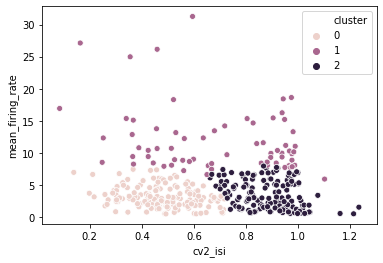

In [78]:
X = df2[["mean_firing_rate", "cv2_isi"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)

model = GaussianMixture(3)
model.fit(X)
Y = model.predict(X)
df2["cluster"] = Y
df2["cluster"] = df["cluster"]

sns.scatterplot(data=df2, x="cv2_isi", y="mean_firing_rate", hue="cluster")
plt.show()

### Add Cluster Labels

In [93]:
df2["cluster"] = df2.cluster.map({0: "slow_regular", 1: "fast_firing", 2: "slow_irregular"})

### Merge and Save Data

In [114]:
df_baseline = (df2
    .pipe(lambda x: pd.merge(x, df1, how="outer"))
    .pipe(lambda x: pd.merge(x, neurons, how="outer", left_on="neuron_id", right_on="id"))
)
               
df_baseline["neuron_id"] = df_baseline["neuron_id"].fillna(df_baseline["id"])

df_baseline = df_baseline.drop(["recording_session_id", "cluster_id", "clusterkm", "id"], axis=1)

df_baseline["cluster"] = df_baseline["cluster"].fillna("no_baseline")



data_dir = Path(".").absolute().parent / "data"
data_dir.mkdir(exist_ok=True)

df_baseline.to_csv(data_dir / "acute_baseline.csv")